# Analisis de RMSD de diversas proteinas
Con el fin de encontrar el mejor filtro para no hacer comparaciones inecesarias se proponen dos filtros:
1. Analizar el RMSD de comparacion de proteinas y en cuales las que solo se agruparon con un solo clique cual es el rmsd promedio y y obtener un corte para reducir el numero de iteraciones.

2. Generar una esfera promedio con los puntos del clique y obtener la diferencia de los centros entre cada uno de los puntos para saber la distancia minima que estaran separados antes de rotarlos.

de 2 seria obteniendo la distancia promedio del origen a cada punto y calculando la diferencia entre cada candidato. y esa diferencia de distancias tiene que estar entre un cierto rango para ser un candidato despues del RMSD

In [1]:
# librerias que utilizaras
import numpy as np
# por si no te lee las tools o functions creadas
import sys
# herramientas para leer pdbs
import read_pdb_tools as rpt
# calculo de distancia
from scipy.spatial.distance import pdist, squareform
# libreria de tablas
import pandas as pd
# funciones de click generadas en pandas
import funciones_CLICK as fc
# iteradores
import itertools as it
# cuenta tiempo de ejecucion
import datetime

#distancia
from scipy.spatial import distance    
    
import multiprocessing
from functools import partial

import cufflinks as cf
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Proteinas 1xxa vs 1tig

In [2]:
# assert( len(sys.argv) > 1)
# lectura de archivo
file1 = '1xxa.pdb' # sys.argv[1]
file2 = '1tig.pdb' # sys.argv[2]

# numero de cliques, preguntar en el software para generalizarlo...
num_cliques = 3

# se define la estructura
pdb1 = rpt.PdbStruct("first")
pdb2 = rpt.PdbStruct("second")

# se lee el pdb y se agrega al objeto
pdb1.AddPdbData("%s" % file1)
pdb2.AddPdbData("%s" % file2)

# se obtienen los residuos que perteneces a la cadena de interes por default chain = 'A'
pdb11 = pdb1.GetResChain()
pdb22 = pdb2.GetResChain()

ss1 = pdb1.Get_SS(file1)
ss2 = pdb1.Get_SS(file2)

In [3]:
# se crea atributo a cada residuo
for i, j in zip(pdb11, ss1.structure.values):
    setattr(i, 'structure', j)
for i, j in zip(pdb22, ss2.structure.values):
    setattr(i, 'structure', j)

In [4]:
def get_df_distancias(ref):
    """Funcion para obtener el dataframe de distancias de cada proteina"""
    # se generan listas con coordenadas y numero de atomo
    coord = [res.GetAtom('CA').coord for res in ref]
    index = [res.resi for res in ref]

    # calcula distancia y regresa dataframe
    distancias = []
    # se calcula la distancia euclidiana entre cada atomo de carbon alfalfa
    for v in coord:
        distancia_un_atomo = []
        for av in coord:
            distancia = pdist(np.array([v, av]), metric='euclidean').item()
            distancia_un_atomo.append(distancia)
        distancias.append(distancia_un_atomo)

    # se genera la matriz de adyacencias para la red
    df_da = pd.DataFrame(index=index, columns=index, data=distancias)
    return(df_da, index)


df_distancias1, index1 = get_df_distancias(pdb11)
df_distancias2, index2 = get_df_distancias(pdb22)

In [5]:
# se generan cliques, tte devuleve dataframe con cliques de 3 y la lista de cliques sin partir
df_cliques1, cliques1 = fc.gen_3_cliques(df_distancias1, dth=10, k=num_cliques)
print('**'*50)
df_cliques2, cliques2 = fc.gen_3_cliques(df_distancias2, dth=10, k=num_cliques)
print('**'*50)

numero de cliques maximos encontrados: 158
numero de 3-cliques posibles: 1787
****************************************************************************************************
numero de cliques maximos encontrados: 246
numero de 3-cliques posibles: 2102
****************************************************************************************************


In [6]:
def get_df_ca(list_of_residues):
    """Genera dataframe con la informacion necesaria para las siguientes funciones
    FALTA DOCUMENTAR ESTA COSA!!!!"""
    #crear df_ca
    atom_number = []
    atom_name = []
    residue_name = []
    residue_number = []
    coord = []
    for res in list_of_residues:
        for atom in res.atoms:
            atom_number.append(atom.atom_number)
            atom_name.append(atom.name)
            residue_name.append(res.resn)
            residue_number.append(res.resi)
            coord.append(atom.coord)

    df_atoms = pd.DataFrame(columns=['atom_number', 'atom_name', 'residue_name',
                                   'residue_number', 'vector'])
    df_atoms.atom_number = atom_number
    df_atoms.atom_name = atom_name
    df_atoms.residue_name = residue_name
    df_atoms.residue_number = residue_number
    df_atoms.vector = coord

    return(df_atoms)


# CREAR DF_atomos_CA #
df_atoms1 = get_df_ca(pdb11)
df_atoms2 = get_df_ca(pdb22)

In [7]:
# se le pega la estructura secundaria al dataframe de los cliques
# esto va a cambiar por que lo tiene que obtener del objeto residuo
# ya se crea en ss1 y no cuesta reevaluar si es mejor desde el residuo
# checar que es mas rapido si desde residuo o desde dataframe ss
df_cliques1 = fc.paste_SS(ss1, df_cliques1, num_cliques = num_cliques)
df_cliques2 = fc.paste_SS(ss2, df_cliques2, num_cliques = num_cliques)

In [8]:
# comparacion SSM #aqui se obtienen los candidatos posibles pasando el filtro de SS
candidatos_ss = fc.compare_SS(df_cliques1,df_cliques2, num_cliques=num_cliques)

In [9]:
# get coords of cliques
df_cliques1 = fc.get_coords_clique(df_atoms1, df_cliques1, num_cliques)
df_cliques2 = fc.get_coords_clique(df_atoms2, df_cliques2, num_cliques)

In [10]:
# baricentro clique
df_cliques1 = fc.baricenter_clique(df_cliques1, num_cliques)
df_cliques2 = fc.baricenter_clique(df_cliques2, num_cliques)

In [11]:
# vectores gorro
df_cliques1 = fc.center_vectors(df_cliques1, num_cliques)
df_cliques2 = fc.center_vectors(df_cliques2, num_cliques)

In [12]:
idx_rmsd1, idx_rmsd2 = 3*num_cliques, 4*num_cliques+3
# print(list(range(idx_rmsd1,idx_rmsd2)))
# se pasan a numpy arrays para mayor rapidez
array_df_cliques1 = df_cliques1.values[:, range(idx_rmsd1, idx_rmsd2)] #del 9 al 15
array_df_cliques2 = df_cliques2.values[:, range(idx_rmsd1, idx_rmsd2)]

In [13]:
#calculo del RMSD
print(len(candidatos_ss))

1705808


In [14]:
restriccion_rmsd = 0.15
if num_cliques == 4:
    restriccion_rmsd = 0.30
if num_cliques == 5:
    restriccion_rmsd = 0.60
if num_cliques == 7:
    restriccion_rmsd = 1.50
if num_cliques == 8:
    restriccion_rmsd = 1.80

In [15]:
%%time
p = multiprocessing.Pool()
rmsd_1 = p.map(partial(fc.calculate_rmsd_rot_trans_m,  
                    array_cliques1 = array_df_cliques1, 
                    array_cliques2 = array_df_cliques2, 
                    num_cliques = num_cliques), candidatos_ss)

print('numero de candidatos:', len(rmsd_1))

numero de candidatos: 1705808
CPU times: user 10.5 s, sys: 308 ms, total: 10.8 s
Wall time: 1min 24s


Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
Traceback (most recent call last):
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/queues.py", line 3

### Analisis de RMSD para saber donde esta el minimo

In [16]:
rmsd_candidatos = pd.DataFrame(rmsd_1)
rmsd_candidatos = rmsd_candidatos[rmsd_candidatos[0] <= restriccion_rmsd]
rmsd_candidatos.columns = ['rmsd','index_candidatos']
rmsd_candidatos.rmsd.count()

6907

In [17]:
serie_rmsd = rmsd_candidatos.rmsd
q5 = serie_rmsd.quantile(0.05)
q10 = serie_rmsd.quantile(0.1)
q20 = serie_rmsd.quantile(0.2)

q5count = serie_rmsd[serie_rmsd <=q5].count()
q10count = serie_rmsd[serie_rmsd <=q10].count()
q20count = serie_rmsd[serie_rmsd <=q20].count()


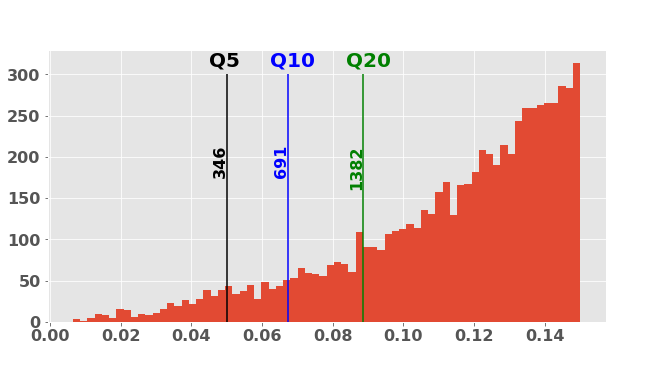

In [18]:
serie_rmsd.hist(bins=70,figsize = (10,5))
plt.title('''Distribucion de rmsd de candidatos despues de comparacion 
          para encontrar corte optimo de las proteinas 1xxa y 1tig''', color='w',fontsize= 20)
plt.vlines(q5,0,300)
plt.text(q5-0.005,310,'Q5', fontsize=20)
plt.text(q5-0.004, 200,q5count, fontsize=16,rotation=90)
plt.vlines(q10,0,300, color = 'b')
plt.text(q10-0.005,310,'Q10',color = 'b',fontsize=20)
plt.text(q10-0.004, 200,q10count, fontsize=16,rotation=90, color='b')
plt.vlines(q20,0,300, color ='g')
plt.text(q20-0.005,310,'Q20',color = 'g',fontsize=20)
plt.text(q20-0.004, 200,q20count, fontsize=16,rotation=90,color='g')
plt.xlabel('RMSD', color='w')
plt.savefig('distribucion_rmsd.jpg')

In [19]:
rmsd_candidatos.describe()

,rmsd
count,6907.00000
mean,0.11314
std,0.03040
min,0.00648
25%,0.09610
50%,0.12134
75%,0.13724
max,0.15000


In [20]:
rmsd_candidatos['cand1'] = rmsd_candidatos.index_candidatos.str[0]
rmsd_candidatos['cand2'] = rmsd_candidatos.index_candidatos.str[1]

In [21]:
agrupado = rmsd_candidatos.groupby('cand1').count()
agrupado_a = agrupado.index[agrupado.rmsd < 3]

In [22]:
rmsd_candidatos[rmsd_candidatos.cand1.isin(agrupado_a)].rmsd.describe()

count   408.00000
mean    0.11885  
std     0.02672  
min     0.03645  
25%     0.10664  
50%     0.12557  
75%     0.13924  
max     0.14995  
Name: rmsd, dtype: float64

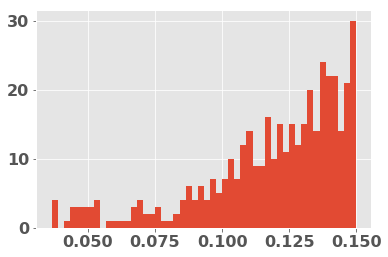

In [23]:
rmsd_candidatos[rmsd_candidatos.cand1.isin(agrupado_a)].rmsd.hist(bins=50)

In [24]:
candidatos_rmsd = rmsd_candidatos[rmsd_candidatos.cand1.isin(agrupado_a)]

Text(0.5,0,'RMSD')

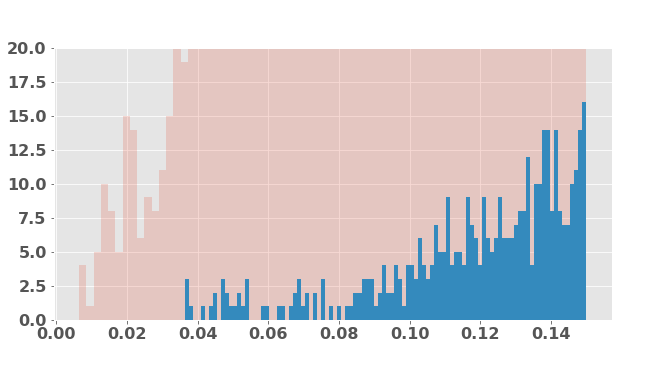

In [25]:
serie_rmsd.hist(bins=70,figsize = (10,5),alpha=0.2)
candidatos_rmsd.rmsd.hist(bins=100)
plt.title("""Comparacion de histogramas entre el general y los 
                candidatos que solo se acoplan con a lo mas 2 candidatos""", color='w', fontsize = 18)
plt.ylim(0,20)
plt.xlabel('RMSD', fontsize = 16, color= 'w')

## Analisis de distancia promedio minima (Esfera promedio)

Obtener el rango de la diferencia de distancia sea adecuado para encontrar cnadidatos

In [26]:
from scipy.spatial import distance
a = (0,0,0)

df_cliques1['distancia_promedio'] = [np.mean([distance.euclidean(a, i[0]),distance.euclidean(a, i[1]),distance.euclidean(a, i[2])]) for i in df_cliques1.vectores_gorro]
df_cliques2['distancia_promedio'] = [np.mean([distance.euclidean(a, i[0]),distance.euclidean(a, i[1]),distance.euclidean(a, i[2])]) for i in df_cliques2.vectores_gorro]

array_dist_promedio1 = df_cliques1.values[:, 15] #del 9 al 15
array_dist_promedio2 = df_cliques2.values[:, 15]

diff_distancia = [array_dist_promedio1[i] - array_dist_promedio2[j] for i,j in candidatos_ss]
print(len(diff_distancia))

1705808


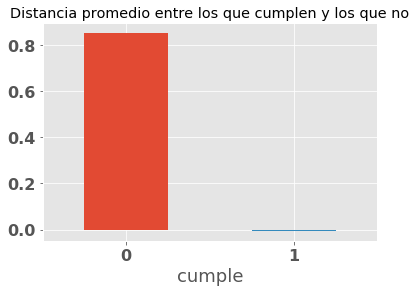

In [27]:
f1 = pd.DataFrame(rmsd_1)
f1['diff_distance'] = diff_distancia
f1.columns = ['rmsd','candidatos','diff_distancia']
f1['cumple'] = np.where(f1.rmsd <= restriccion_rmsd,1,0)
f1.groupby('cumple').diff_distancia.mean().plot.bar(rot = 0,title='Distancia promedio entre los que cumplen y los que no')


In [28]:
f1.groupby('cumple').diff_distancia.describe().T

cumple,0,1
count,1698901.00000,6907.00000
mean,0.85053,-0.00603
std,2.53168,0.18670
min,-6.59739,-0.43448
25%,-0.99927,-0.13911
50%,0.56545,-0.00890
75%,2.78687,0.12369
max,9.48316,0.43953


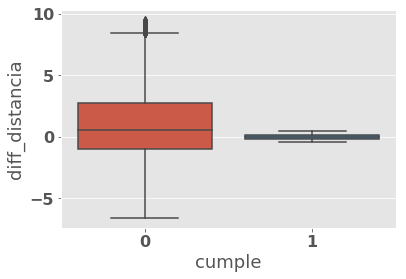

In [29]:
sns.boxplot(x="cumple", y="diff_distancia",data=f1)

In [30]:
limit = 0.5
f1[(f1.diff_distancia > -limit) & (f1.diff_distancia < limit)].groupby('cumple').rmsd.count()

cumple
0    273733
1    6907  
Name: rmsd, dtype: int64

--------------------

## Proteinas 1phr vs 1tig

In [31]:
# assert( len(sys.argv) > 1)
# lectura de archivo
file1 = '1phr.pdb' # sys.argv[1]
file2 = '1tig.pdb' # sys.argv[2]

# numero de cliques, preguntar en el software para generalizarlo...
num_cliques = 3

# se define la estructura
pdb1 = rpt.PdbStruct("first")
pdb2 = rpt.PdbStruct("second")

# se lee el pdb y se agrega al objeto
pdb1.AddPdbData("%s" % file1)
pdb2.AddPdbData("%s" % file2)

# se obtienen los residuos que perteneces a la cadena de interes por default chain = 'A'
pdb11 = pdb1.GetResChain()
pdb22 = pdb2.GetResChain()

ss1 = pdb1.Get_SS(file1)
ss2 = pdb1.Get_SS(file2)

In [32]:
# se crea atributo a cada residuo
for i, j in zip(pdb11, ss1.structure.values):
    setattr(i, 'structure', j)
for i, j in zip(pdb22, ss2.structure.values):
    setattr(i, 'structure', j)

In [33]:
def get_df_distancias(ref):
    """Funcion para obtener el dataframe de distancias de cada proteina"""
    # se generan listas con coordenadas y numero de atomo
    coord = [res.GetAtom('CA').coord for res in ref]
    index = [res.resi for res in ref]

    # calcula distancia y regresa dataframe
    distancias = []
    # se calcula la distancia euclidiana entre cada atomo de carbon alfalfa
    for v in coord:
        distancia_un_atomo = []
        for av in coord:
            distancia = pdist(np.array([v, av]), metric='euclidean').item()
            distancia_un_atomo.append(distancia)
        distancias.append(distancia_un_atomo)

    # se genera la matriz de adyacencias para la red
    df_da = pd.DataFrame(index=index, columns=index, data=distancias)
    return(df_da, index)


df_distancias1, index1 = get_df_distancias(pdb11)
df_distancias2, index2 = get_df_distancias(pdb22)

In [34]:
# se generan cliques, tte devuleve dataframe con cliques de 3 y la lista de cliques sin partir
df_cliques1, cliques1 = fc.gen_3_cliques(df_distancias1, dth=10, k=num_cliques)
print('**'*50)
df_cliques2, cliques2 = fc.gen_3_cliques(df_distancias2, dth=10, k=num_cliques)
print('**'*50)

numero de cliques maximos encontrados: 419
numero de 3-cliques posibles: 4480
****************************************************************************************************
numero de cliques maximos encontrados: 246
numero de 3-cliques posibles: 2102
****************************************************************************************************


In [35]:
def get_df_ca(list_of_residues):
    """Genera dataframe con la informacion necesaria para las siguientes funciones
    FALTA DOCUMENTAR ESTA COSA!!!!"""
    #crear df_ca
    atom_number = []
    atom_name = []
    residue_name = []
    residue_number = []
    coord = []
    for res in list_of_residues:
        for atom in res.atoms:
            atom_number.append(atom.atom_number)
            atom_name.append(atom.name)
            residue_name.append(res.resn)
            residue_number.append(res.resi)
            coord.append(atom.coord)

    df_atoms = pd.DataFrame(columns=['atom_number', 'atom_name', 'residue_name',
                                   'residue_number', 'vector'])
    df_atoms.atom_number = atom_number
    df_atoms.atom_name = atom_name
    df_atoms.residue_name = residue_name
    df_atoms.residue_number = residue_number
    df_atoms.vector = coord

    return(df_atoms)


# CREAR DF_atomos_CA #
df_atoms1 = get_df_ca(pdb11)
df_atoms2 = get_df_ca(pdb22)

In [36]:
# se le pega la estructura secundaria al dataframe de los cliques
# esto va a cambiar por que lo tiene que obtener del objeto residuo
# ya se crea en ss1 y no cuesta reevaluar si es mejor desde el residuo
# checar que es mas rapido si desde residuo o desde dataframe ss
df_cliques1 = fc.paste_SS(ss1, df_cliques1, num_cliques = num_cliques)
df_cliques2 = fc.paste_SS(ss2, df_cliques2, num_cliques = num_cliques)

In [37]:
# comparacion SSM #aqui se obtienen los candidatos posibles pasando el filtro de SS
candidatos_ss = fc.compare_SS(df_cliques1,df_cliques2, num_cliques=num_cliques)

In [38]:
# get coords of cliques
df_cliques1 = fc.get_coords_clique(df_atoms1, df_cliques1, num_cliques)
df_cliques2 = fc.get_coords_clique(df_atoms2, df_cliques2, num_cliques)

In [39]:
# baricentro clique
df_cliques1 = fc.baricenter_clique(df_cliques1, num_cliques)
df_cliques2 = fc.baricenter_clique(df_cliques2, num_cliques)

In [40]:
# vectores gorro
df_cliques1 = fc.center_vectors(df_cliques1, num_cliques)
df_cliques2 = fc.center_vectors(df_cliques2, num_cliques)

In [41]:
idx_rmsd1, idx_rmsd2 = 3*num_cliques, 4*num_cliques+3
# print(list(range(idx_rmsd1,idx_rmsd2)))
# se pasan a numpy arrays para mayor rapidez
array_df_cliques1 = df_cliques1.values[:, range(idx_rmsd1, idx_rmsd2)] #del 9 al 15
array_df_cliques2 = df_cliques2.values[:, range(idx_rmsd1, idx_rmsd2)]

In [42]:
#calculo del RMSD
print(len(candidatos_ss))

4409669


In [43]:
restriccion_rmsd = 0.15
if num_cliques == 4:
    restriccion_rmsd = 0.30
if num_cliques == 5:
    restriccion_rmsd = 0.60
if num_cliques == 7:
    restriccion_rmsd = 1.50
if num_cliques == 8:
    restriccion_rmsd = 1.80

In [44]:
%%time
p = multiprocessing.Pool(multiprocessing.cpu_count() -1)
rmsd_1 = p.map(partial(fc.calculate_rmsd_rot_trans_m,  
                    array_cliques1 = array_df_cliques1, 
                    array_cliques2 = array_df_cliques2, 
                    num_cliques = num_cliques), candidatos_ss)

print('numero de candidatos:', len(rmsd_1))

numero de candidatos: 4409669
CPU times: user 18.6 s, sys: 745 ms, total: 19.4 s
Wall time: 3min 47s


Process ForkPoolWorker-10:
Process ForkPoolWorker-15:
Process ForkPoolWorker-14:
Process ForkPoolWorker-13:
Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwar

### Analisis de RMSD para saber donde esta el minimo

In [45]:
rmsd_candidatos = pd.DataFrame(rmsd_1)
rmsd_candidatos = rmsd_candidatos[rmsd_candidatos[0] <= restriccion_rmsd]
rmsd_candidatos.columns = ['rmsd','index_candidatos']
rmsd_candidatos.rmsd.count()

17822

In [46]:
serie_rmsd = rmsd_candidatos.rmsd
q5 = serie_rmsd.quantile(0.05)
q10 = serie_rmsd.quantile(0.1)
q20 = serie_rmsd.quantile(0.2)

q5count = serie_rmsd[serie_rmsd <=q5].count()
q10count = serie_rmsd[serie_rmsd <=q10].count()
q20count = serie_rmsd[serie_rmsd <=q20].count()


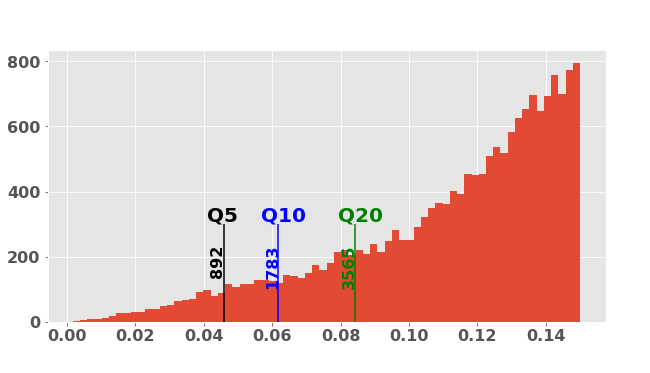

In [52]:
serie_rmsd.hist(bins=70,figsize = (10,5))
plt.title('''Distribucion de rmsd de candidatos despues de comparacion 
          para encontrar corte optimo de las proteinas 1phr y 1tig''', color='w',fontsize= 20)
plt.vlines(q5,0,300)
plt.text(q5-0.005,310,'Q5', fontsize=20)
plt.text(q5-0.004, 200,q5count, fontsize=16,rotation=90)
plt.vlines(q10,0,300, color = 'b')
plt.text(q10-0.005,310,'Q10',color = 'b',fontsize=20)
plt.text(q10-0.004, 200,q10count, fontsize=16,rotation=90, color='b')
plt.vlines(q20,0,300, color ='g')
plt.text(q20-0.005,310,'Q20',color = 'g',fontsize=20)
plt.text(q20-0.004, 200,q20count, fontsize=16,rotation=90,color='g')
plt.xlabel('RMSD', color='w')
plt.savefig('distribucion_rmsd.jpg')

In [53]:
rmsd_candidatos.describe()

,rmsd,cand1,cand2
count,17822.00000,17822.00000,17822.00000
mean,0.11156,2839.96521,1146.20548
std,0.03191,1091.26215,686.60583
min,0.00186,3.00000,0.00000
25%,0.09284,2134.00000,659.00000
50%,0.12048,2909.00000,1384.00000
75%,0.13703,3776.00000,1803.00000
max,0.15000,4479.00000,2100.00000


In [54]:
rmsd_candidatos['cand1'] = rmsd_candidatos.index_candidatos.str[0]
rmsd_candidatos['cand2'] = rmsd_candidatos.index_candidatos.str[1]

In [55]:
agrupado = rmsd_candidatos.groupby('cand1').count()
agrupado_a = agrupado.index[agrupado.rmsd < 3]

In [56]:
rmsd_candidatos[rmsd_candidatos.cand1.isin(agrupado_a)].rmsd.describe()

count   797.00000
mean    0.11963  
std     0.02570  
min     0.02684  
25%     0.10456  
50%     0.12618  
75%     0.14042  
max     0.15000  
Name: rmsd, dtype: float64

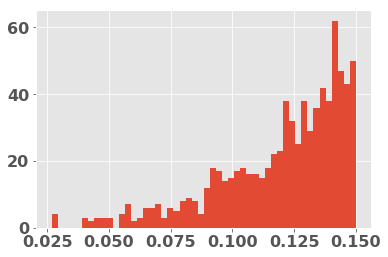

In [57]:
rmsd_candidatos[rmsd_candidatos.cand1.isin(agrupado_a)].rmsd.hist(bins=50)

In [58]:
candidatos_rmsd = rmsd_candidatos[rmsd_candidatos.cand1.isin(agrupado_a)]

Text(0.5,0,'RMSD')

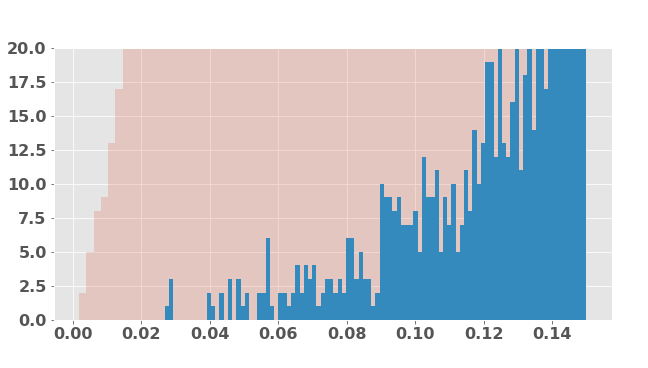

In [59]:
serie_rmsd.hist(bins=70,figsize = (10,5),alpha=0.2)
candidatos_rmsd.rmsd.hist(bins=100)
plt.title("""Comparacion de histogramas entre el general y los 
                candidatos que solo se acoplan con a lo mas 2 candidatos""", color='w', fontsize = 18)
plt.ylim(0,20)
plt.xlabel('RMSD', fontsize = 16, color= 'w')

Distancia

In [60]:
from scipy.spatial import distance
a = (0,0,0)

df_cliques1['distancia_promedio'] = [np.mean([distance.euclidean(a, i[0]),distance.euclidean(a, i[1]),distance.euclidean(a, i[2])]) for i in df_cliques1.vectores_gorro]
df_cliques2['distancia_promedio'] = [np.mean([distance.euclidean(a, i[0]),distance.euclidean(a, i[1]),distance.euclidean(a, i[2])]) for i in df_cliques2.vectores_gorro]

array_dist_promedio1 = df_cliques1.values[:, 15] #del 9 al 15
array_dist_promedio2 = df_cliques2.values[:, 15]

diff_distancia = [array_dist_promedio1[i] - array_dist_promedio2[j] for i,j in candidatos_ss]
print(len(diff_distancia))

4409669


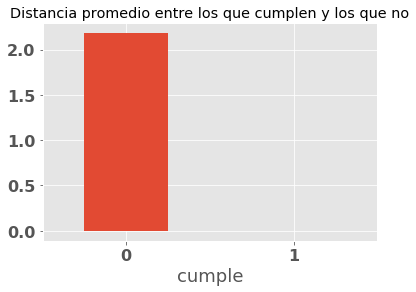

In [61]:
f1 = pd.DataFrame(rmsd_1)
f1['diff_distance'] = diff_distancia
f1.columns = ['rmsd','candidatos','diff_distancia']
f1['cumple'] = np.where(f1.rmsd <= restriccion_rmsd,1,0)
f1.groupby('cumple').diff_distancia.mean().plot.bar(rot = 0,title='Distancia promedio entre los que cumplen y los que no')


In [62]:
f1.groupby('cumple').diff_distancia.describe().T

cumple,0,1
count,4391847.00000,17822.00000
mean,2.18070,-0.00144
std,3.52575,0.18870
min,-6.59041,-0.44323
25%,-0.44124,-0.13173
50%,1.71347,-0.00411
75%,4.63639,0.13372
max,13.42837,0.44477


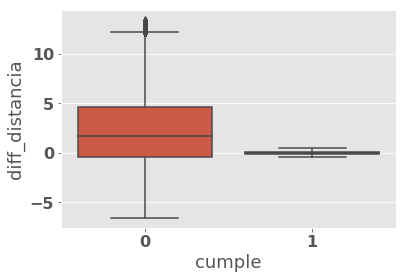

In [63]:
sns.boxplot(x="cumple", y="diff_distancia",data=f1)

In [64]:
limit = 0.5
f1[(f1.diff_distancia > -limit) & (f1.diff_distancia < limit)].groupby('cumple').rmsd.count()

cumple
0    549624
1    17822 
Name: rmsd, dtype: int64

-----------

## Proteinas 1xxa vs 1phr

In [65]:
# assert( len(sys.argv) > 1)
# lectura de archivo
file1 = '1xxa.pdb' # sys.argv[1]
file2 = '1phr.pdb' # sys.argv[2]

# numero de cliques, preguntar en el software para generalizarlo...
num_cliques = 3

# se define la estructura
pdb1 = rpt.PdbStruct("first")
pdb2 = rpt.PdbStruct("second")

# se lee el pdb y se agrega al objeto
pdb1.AddPdbData("%s" % file1)
pdb2.AddPdbData("%s" % file2)

# se obtienen los residuos que perteneces a la cadena de interes por default chain = 'A'
pdb11 = pdb1.GetResChain()
pdb22 = pdb2.GetResChain()

ss1 = pdb1.Get_SS(file1)
ss2 = pdb1.Get_SS(file2)

In [66]:
# se crea atributo a cada residuo
for i, j in zip(pdb11, ss1.structure.values):
    setattr(i, 'structure', j)
for i, j in zip(pdb22, ss2.structure.values):
    setattr(i, 'structure', j)

In [67]:
def get_df_distancias(ref):
    """Funcion para obtener el dataframe de distancias de cada proteina"""
    # se generan listas con coordenadas y numero de atomo
    coord = [res.GetAtom('CA').coord for res in ref]
    index = [res.resi for res in ref]

    # calcula distancia y regresa dataframe
    distancias = []
    # se calcula la distancia euclidiana entre cada atomo de carbon alfalfa
    for v in coord:
        distancia_un_atomo = []
        for av in coord:
            distancia = pdist(np.array([v, av]), metric='euclidean').item()
            distancia_un_atomo.append(distancia)
        distancias.append(distancia_un_atomo)

    # se genera la matriz de adyacencias para la red
    df_da = pd.DataFrame(index=index, columns=index, data=distancias)
    return(df_da, index)


df_distancias1, index1 = get_df_distancias(pdb11)
df_distancias2, index2 = get_df_distancias(pdb22)

In [68]:
# se generan cliques, tte devuleve dataframe con cliques de 3 y la lista de cliques sin partir
df_cliques1, cliques1 = fc.gen_3_cliques(df_distancias1, dth=10, k=num_cliques)
print('**'*50)
df_cliques2, cliques2 = fc.gen_3_cliques(df_distancias2, dth=10, k=num_cliques)
print('**'*50)

numero de cliques maximos encontrados: 158
numero de 3-cliques posibles: 1787
****************************************************************************************************
numero de cliques maximos encontrados: 246
numero de 3-cliques posibles: 2102
****************************************************************************************************


In [69]:
def get_df_ca(list_of_residues):
    """Genera dataframe con la informacion necesaria para las siguientes funciones
    FALTA DOCUMENTAR ESTA COSA!!!!"""
    #crear df_ca
    atom_number = []
    atom_name = []
    residue_name = []
    residue_number = []
    coord = []
    for res in list_of_residues:
        for atom in res.atoms:
            atom_number.append(atom.atom_number)
            atom_name.append(atom.name)
            residue_name.append(res.resn)
            residue_number.append(res.resi)
            coord.append(atom.coord)

    df_atoms = pd.DataFrame(columns=['atom_number', 'atom_name', 'residue_name',
                                   'residue_number', 'vector'])
    df_atoms.atom_number = atom_number
    df_atoms.atom_name = atom_name
    df_atoms.residue_name = residue_name
    df_atoms.residue_number = residue_number
    df_atoms.vector = coord

    return(df_atoms)


# CREAR DF_atomos_CA #
df_atoms1 = get_df_ca(pdb11)
df_atoms2 = get_df_ca(pdb22)

In [70]:
# se le pega la estructura secundaria al dataframe de los cliques
# esto va a cambiar por que lo tiene que obtener del objeto residuo
# ya se crea en ss1 y no cuesta reevaluar si es mejor desde el residuo
# checar que es mas rapido si desde residuo o desde dataframe ss
df_cliques1 = fc.paste_SS(ss1, df_cliques1, num_cliques = num_cliques)
df_cliques2 = fc.paste_SS(ss2, df_cliques2, num_cliques = num_cliques)

In [71]:
# comparacion SSM #aqui se obtienen los candidatos posibles pasando el filtro de SS
candidatos_ss = fc.compare_SS(df_cliques1,df_cliques2, num_cliques=num_cliques)

In [72]:
# get coords of cliques
df_cliques1 = fc.get_coords_clique(df_atoms1, df_cliques1, num_cliques)
df_cliques2 = fc.get_coords_clique(df_atoms2, df_cliques2, num_cliques)

In [73]:
# baricentro clique
df_cliques1 = fc.baricenter_clique(df_cliques1, num_cliques)
df_cliques2 = fc.baricenter_clique(df_cliques2, num_cliques)

In [74]:
# vectores gorro
df_cliques1 = fc.center_vectors(df_cliques1, num_cliques)
df_cliques2 = fc.center_vectors(df_cliques2, num_cliques)

In [75]:
idx_rmsd1, idx_rmsd2 = 3*num_cliques, 4*num_cliques+3
# print(list(range(idx_rmsd1,idx_rmsd2)))
# se pasan a numpy arrays para mayor rapidez
array_df_cliques1 = df_cliques1.values[:, range(idx_rmsd1, idx_rmsd2)] #del 9 al 15
array_df_cliques2 = df_cliques2.values[:, range(idx_rmsd1, idx_rmsd2)]

In [76]:
#calculo del RMSD
print(len(candidatos_ss))

1705808


In [77]:
restriccion_rmsd = 0.15
if num_cliques == 4:
    restriccion_rmsd = 0.30
if num_cliques == 5:
    restriccion_rmsd = 0.60
if num_cliques == 7:
    restriccion_rmsd = 1.50
if num_cliques == 8:
    restriccion_rmsd = 1.80

In [78]:
%%time
p = multiprocessing.Pool()
rmsd_1 = p.map(partial(fc.calculate_rmsd_rot_trans_m,  
                    array_cliques1 = array_df_cliques1, 
                    array_cliques2 = array_df_cliques2, 
                    num_cliques = num_cliques), candidatos_ss)

print('numero de candidatos:', len(rmsd_1))

Process ForkPoolWorker-16:
Process ForkPoolWorker-21:
Process ForkPoolWorker-17:
Traceback (most recent call last):
Process ForkPoolWorker-18:
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/serch/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
Traceback (most recent call last):
  File "/home/serch/pdbmani/Serch/funciones_CLICK.py", line 578, in calculate_rmsd_rot_trans_m
    array_cliques2[:, 0][res2], dtype=np.float64)) # antes 9 #PROBABLE CAMBIAR
  File "/home/serch/pdbmani/Serch/funciones_CLICK.py", line 568, in rmsd_between_cliques
    rmsd_final = rmsd_i(p12).mean()
  File "/home/serch/anacond

KeyboardInterrupt: 

### Analisis de RMSD para saber donde esta el minimo

In [79]:
rmsd_candidatos = pd.DataFrame(rmsd_1)
rmsd_candidatos = rmsd_candidatos[rmsd_candidatos[0] <= restriccion_rmsd]
rmsd_candidatos.columns = ['rmsd','index_candidatos']
rmsd_candidatos.rmsd.count()

17822

In [80]:
serie_rmsd = rmsd_candidatos.rmsd
q5 = serie_rmsd.quantile(0.05)
q10 = serie_rmsd.quantile(0.1)
q20 = serie_rmsd.quantile(0.2)

q5count = serie_rmsd[serie_rmsd <=q5].count()
q10count = serie_rmsd[serie_rmsd <=q10].count()
q20count = serie_rmsd[serie_rmsd <=q20].count()


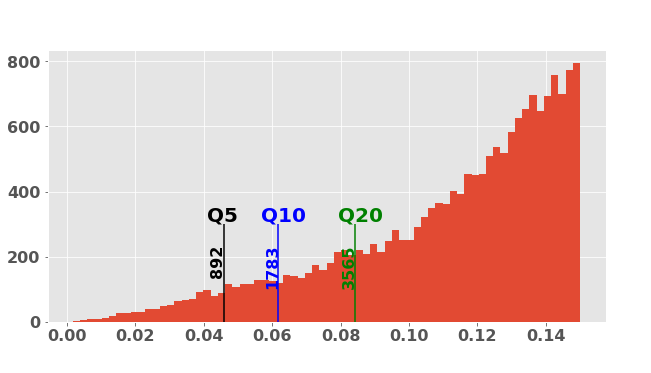

In [81]:
serie_rmsd.hist(bins=70,figsize = (10,5))
plt.title('''Distribucion de rmsd de candidatos despues de comparacion 
          para encontrar corte optimo de las proteinas 1xxa y 1tig''', color='w',fontsize= 20)
plt.vlines(q5,0,300)
plt.text(q5-0.005,310,'Q5', fontsize=20)
plt.text(q5-0.004, 200,q5count, fontsize=16,rotation=90)
plt.vlines(q10,0,300, color = 'b')
plt.text(q10-0.005,310,'Q10',color = 'b',fontsize=20)
plt.text(q10-0.004, 200,q10count, fontsize=16,rotation=90, color='b')
plt.vlines(q20,0,300, color ='g')
plt.text(q20-0.005,310,'Q20',color = 'g',fontsize=20)
plt.text(q20-0.004, 200,q20count, fontsize=16,rotation=90,color='g')
plt.xlabel('RMSD', color='w')
plt.savefig('distribucion_rmsd.jpg')

In [19]:
rmsd_candidatos.describe()

,rmsd
count,6907.00000
mean,0.11314
std,0.03040
min,0.00648
25%,0.09610
50%,0.12134
75%,0.13724
max,0.15000


In [20]:
rmsd_candidatos['cand1'] = rmsd_candidatos.index_candidatos.str[0]
rmsd_candidatos['cand2'] = rmsd_candidatos.index_candidatos.str[1]

In [21]:
agrupado = rmsd_candidatos.groupby('cand1').count()
agrupado_a = agrupado.index[agrupado.rmsd < 3]

In [22]:
rmsd_candidatos[rmsd_candidatos.cand1.isin(agrupado_a)].rmsd.describe()

count   408.00000
mean    0.11885  
std     0.02672  
min     0.03645  
25%     0.10664  
50%     0.12557  
75%     0.13924  
max     0.14995  
Name: rmsd, dtype: float64

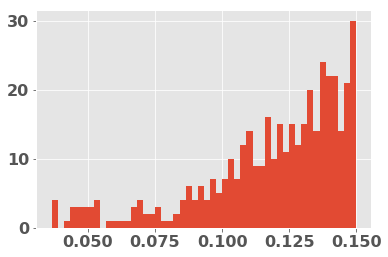

In [23]:
rmsd_candidatos[rmsd_candidatos.cand1.isin(agrupado_a)].rmsd.hist(bins=50)

In [24]:
candidatos_rmsd = rmsd_candidatos[rmsd_candidatos.cand1.isin(agrupado_a)]

Text(0.5,0,'RMSD')

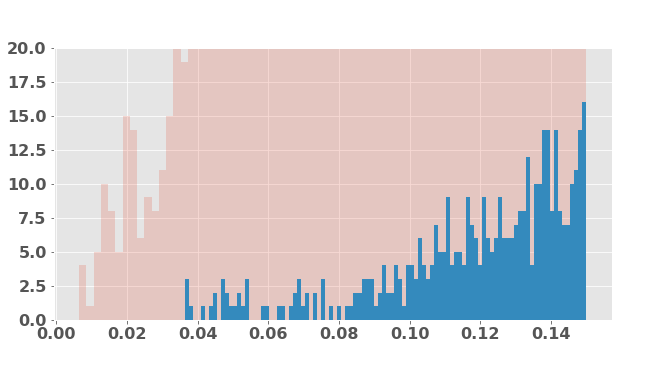

In [25]:
serie_rmsd.hist(bins=70,figsize = (10,5),alpha=0.2)
candidatos_rmsd.rmsd.hist(bins=100)
plt.title("""Comparacion de histogramas entre el general y los 
                candidatos que solo se acoplan con a lo mas 2 candidatos""", color='w', fontsize = 18)
plt.ylim(0,20)
plt.xlabel('RMSD', fontsize = 16, color= 'w')

## Analisis de distancia promedio minima (Esfera promedio)

Obtener el rango de la diferencia de distancia sea adecuado para encontrar cnadidatos

In [26]:
from scipy.spatial import distance
a = (0,0,0)

df_cliques1['distancia_promedio'] = [np.mean([distance.euclidean(a, i[0]),distance.euclidean(a, i[1]),distance.euclidean(a, i[2])]) for i in df_cliques1.vectores_gorro]
df_cliques2['distancia_promedio'] = [np.mean([distance.euclidean(a, i[0]),distance.euclidean(a, i[1]),distance.euclidean(a, i[2])]) for i in df_cliques2.vectores_gorro]

array_dist_promedio1 = df_cliques1.values[:, 15] #del 9 al 15
array_dist_promedio2 = df_cliques2.values[:, 15]

diff_distancia = [array_dist_promedio1[i] - array_dist_promedio2[j] for i,j in candidatos_ss]
print(len(diff_distancia))

1705808


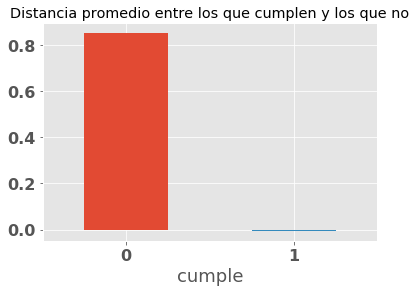

In [27]:
f1 = pd.DataFrame(rmsd_1)
f1['diff_distance'] = diff_distancia
f1.columns = ['rmsd','candidatos','diff_distancia']
f1['cumple'] = np.where(f1.rmsd <= restriccion_rmsd,1,0)
f1.groupby('cumple').diff_distancia.mean().plot.bar(rot = 0,title='Distancia promedio entre los que cumplen y los que no')


In [28]:
f1.groupby('cumple').diff_distancia.describe().T

cumple,0,1
count,1698901.00000,6907.00000
mean,0.85053,-0.00603
std,2.53168,0.18670
min,-6.59739,-0.43448
25%,-0.99927,-0.13911
50%,0.56545,-0.00890
75%,2.78687,0.12369
max,9.48316,0.43953


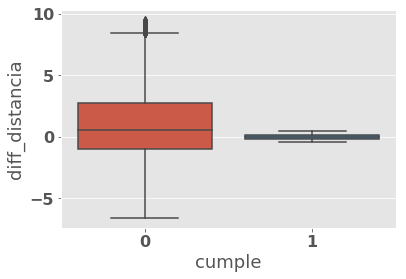

In [29]:
sns.boxplot(x="cumple", y="diff_distancia",data=f1)

In [30]:
limit = 0.5
f1[(f1.diff_distancia > -limit) & (f1.diff_distancia < limit)].groupby('cumple').rmsd.count()

cumple
0    273733
1    6907  
Name: rmsd, dtype: int64

--------------------

# CHECK DE proteinas compatibles

In [2]:
import os
os.getcwd()

'/home/serch/pdbmani/Serch'

In [57]:
cluster = pd.read_csv('/home/serch/Descargas/clusters95.txt', sep='\t', names=[1,2,3])
cluster[cluster[1] == 21250]

,1,2,3
209005,21250,1,5U9M:D
209006,21250,2,1QUP:B
209007,21250,3,1EJ8:A
209008,21250,4,1QUP:A
209009,21250,5,1JK9:B
209010,21250,6,5U9M:B
209011,21250,7,1JK9:D


# Prueba de cuanto tiempo se tarda por cada 1M de candidatos

In [77]:
%%time
p = multiprocessing.Pool(multiprocessing.cpu_count()-1)
rmsd_1 = p.map(partial(fc.calculate_rmsd_rot_trans_m,  
                    array_cliques1 = array_df_cliques1, 
                    array_cliques2 = array_df_cliques2, 
                    num_cliques = num_cliques), candidatos_ss[:int(1e6)])

CPU times: user 8.59 s, sys: 240 ms, total: 8.83 s
Wall time: 49.5 s


__Por cada Millon de candidatos el tiempo de computo estimado es de 45 segundos__

In [17]:
%%timeit
p = multiprocessing.Pool(multiprocessing.cpu_count()-1)
rmsd_1 = p.map(partial(fc.calculate_rmsd_rot_trans_m,  
                    array_cliques1 = array_df_cliques1, 
                    array_cliques2 = array_df_cliques2, 
                    num_cliques = num_cliques), candidatos_ss[:int(1e6)])

51.2 s ± 1.11 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


----------

# Muestreo de proteinas para obtener el rango de distancia donde funciona el filtro

In [111]:
# assert( len(sys.argv) > 1)
# lectura de archivo
file1 = 'pdbs/1xxa.pdb' # sys.argv[1]
file2 = 'pdbs/1tig.pdb' # sys.argv[2]

# numero de cliques, preguntar en el software para generalizarlo...
num_cliques = 4

# se define la estructura
pdb1 = rpt.PdbStruct("first")
pdb2 = rpt.PdbStruct("second")

# se lee el pdb y se agrega al objeto
pdb1.AddPdbData("%s" % file1)
pdb2.AddPdbData("%s" % file2)

# se obtienen los residuos que perteneces a la cadena de interes por default chain = 'A'
pdb11 = pdb1.GetResChain()
pdb22 = pdb2.GetResChain()

ss1 = pdb1.Get_SS(file1)
ss2 = pdb1.Get_SS(file2)

In [112]:
# se crea atributo a cada residuo
for i, j in zip(pdb11, ss1.structure.values):
    setattr(i, 'structure', j)
for i, j in zip(pdb22, ss2.structure.values):
    setattr(i, 'structure', j)

In [113]:
def get_df_distancias(ref):
    """Funcion para obtener el dataframe de distancias de cada proteina"""
    # se generan listas con coordenadas y numero de atomo
    coord = [res.GetAtom('CA').coord for res in ref]
    index = [res.resi for res in ref]

    # calcula distancia y regresa dataframe
    distancias = []
    # se calcula la distancia euclidiana entre cada atomo de carbon alfalfa
    for v in coord:
        distancia_un_atomo = []
        for av in coord:
            distancia = pdist(np.array([v, av]), metric='euclidean').item()
            distancia_un_atomo.append(distancia)
        distancias.append(distancia_un_atomo)

    # se genera la matriz de adyacencias para la red
    df_da = pd.DataFrame(index=index, columns=index, data=distancias)
    return(df_da, index)


df_distancias1, index1 = get_df_distancias(pdb11)
df_distancias2, index2 = get_df_distancias(pdb22)

In [114]:
# se generan cliques, tte devuleve dataframe con cliques de 3 y la lista de cliques sin partir
df_cliques1, cliques1 = fc.gen_3_cliques(df_distancias1, dth=10, k=num_cliques)
print('**'*50)
df_cliques2, cliques2 = fc.gen_3_cliques(df_distancias2, dth=10, k=num_cliques)
print('**'*50)

numero de cliques maximos encontrados: 158
numero de 4-cliques posibles: 2989
****************************************************************************************************
numero de cliques maximos encontrados: 246
numero de 4-cliques posibles: 3106
****************************************************************************************************


In [115]:
def get_df_ca(list_of_residues):
    """Genera dataframe con la informacion necesaria para las siguientes funciones
    FALTA DOCUMENTAR ESTA COSA!!!!"""
    #crear df_ca
    atom_number = []
    atom_name = []
    residue_name = []
    residue_number = []
    coord = []
    for res in list_of_residues:
        for atom in res.atoms:
            atom_number.append(atom.atom_number)
            atom_name.append(atom.name)
            residue_name.append(res.resn)
            residue_number.append(res.resi)
            coord.append(atom.coord)

    df_atoms = pd.DataFrame(columns=['atom_number', 'atom_name', 'residue_name',
                                   'residue_number', 'vector'])
    df_atoms.atom_number = atom_number
    df_atoms.atom_name = atom_name
    df_atoms.residue_name = residue_name
    df_atoms.residue_number = residue_number
    df_atoms.vector = coord

    return(df_atoms)


# CREAR DF_atomos_CA #
df_atoms1 = get_df_ca(pdb11)
df_atoms2 = get_df_ca(pdb22)

In [116]:
# se le pega la estructura secundaria al dataframe de los cliques
# esto va a cambiar por que lo tiene que obtener del objeto residuo
# ya se crea en ss1 y no cuesta reevaluar si es mejor desde el residuo
# checar que es mas rapido si desde residuo o desde dataframe ss
df_cliques1 = fc.paste_SS(ss1, df_cliques1, num_cliques = num_cliques)
df_cliques2 = fc.paste_SS(ss2, df_cliques2, num_cliques = num_cliques)

In [117]:
# comparacion SSM #aqui se obtienen los candidatos posibles pasando el filtro de SS
candidatos_ss = fc.compare_SS(df_cliques1,df_cliques2, num_cliques=num_cliques)

In [118]:
# get coords of cliques
df_cliques1 = fc.get_coords_clique(df_atoms1, df_cliques1, num_cliques)
df_cliques2 = fc.get_coords_clique(df_atoms2, df_cliques2, num_cliques)

In [119]:
# baricentro clique
df_cliques1 = fc.baricenter_clique(df_cliques1, num_cliques)
df_cliques2 = fc.baricenter_clique(df_cliques2, num_cliques)

In [120]:
# vectores gorro
df_cliques1 = fc.center_vectors(df_cliques1, num_cliques)
df_cliques2 = fc.center_vectors(df_cliques2, num_cliques)

In [121]:
idx_rmsd1, idx_rmsd2 = 3*num_cliques, 4*num_cliques+3
# print(list(range(idx_rmsd1,idx_rmsd2)))
# se pasan a numpy arrays para mayor rapidez
array_df_cliques1 = df_cliques1.values[:, range(idx_rmsd1, idx_rmsd2)] #del 9 al 15
array_df_cliques2 = df_cliques2.values[:, range(idx_rmsd1, idx_rmsd2)]

In [122]:
#calculo del RMSD
print(len(candidatos_ss))

3364628


In [147]:
#def get_distance(num_cliques):
a = (0,0,0)
dist = distance.euclidean
if num_cliques == 3:
    df_cliques1['distancia_promedio'] = [np.mean(
    [dist(a, i[0]),dist(a, i[1]),dist(a, i[2])]) for i in df_cliques1.vectores_gorro]
    df_cliques2['distancia_promedio'] = [np.mean(
    [dist(a, i[0]),dist(a, i[1]),dist(a, i[2])]) for i in df_cliques2.vectores_gorro]
    
elif num_cliques == 4:
    df_cliques1['distancia_promedio'] = [np.mean(
    [dist(a, i[0]),dist(a, i[1]),dist(a, i[2]),dist(a, i[3])]) for i in df_cliques1.vectores_gorro]
    df_cliques2['distancia_promedio'] = [np.mean(
    [dist(a, i[0]),dist(a, i[1]),dist(a, i[2]),dist(a, i[3])]) for i in df_cliques2.vectores_gorro]
    
elif num_cliques == 5:
    df_cliques1['distancia_promedio'] = [np.mean(
    [dist(a, i[0]),dist(a, i[1]),dist(a, i[2]),dist(a, i[3]),dist(a, i[4])]) for i in df_cliques1.vectores_gorro]
    df_cliques2['distancia_promedio'] = [np.mean(
    [dist(a, i[0]),dist(a, i[1]),dist(a, i[2]),dist(a, i[3]),dist(a, i[4])]) for i in df_cliques2.vectores_gorro]
    
elif num_cliques == 6:
    df_cliques1['distancia_promedio'] = [np.mean(
    [dist(a, i[0]),dist(a, i[1]),dist(a, i[2]),dist(a, i[3]),dist(a, i[4]),dist(a, i[5])]) for i in df_cliques1.vectores_gorro]
    df_cliques2['distancia_promedio'] = [np.mean(
    [dist(a, i[0]),dist(a, i[1]),dist(a, i[2]),dist(a, i[3]),dist(a, i[4]),dist(a, i[5])]) for i in df_cliques2.vectores_gorro]
    
elif num_cliques == 7:
    df_cliques1['distancia_promedio'] = [np.mean(
    [dist(a, i[0]),dist(a, i[1]),dist(a, i[2]),dist(a, i[3]),dist(a, i[4]),dist(a, i[5]),dist(a, i[6])]) for i in df_cliques1.vectores_gorro]
    df_cliques2['distancia_promedio'] = [np.mean(
    [dist(a, i[0]),dist(a, i[1]),dist(a, i[2]),dist(a, i[3]),dist(a, i[4]),dist(a, i[5]),dist(a, i[6])]) for i in df_cliques2.vectores_gorro]
    
elif num_cliques == 8:
    df_cliques1['distancia_promedio'] = [np.mean(
    [dist(a, i[0]),dist(a, i[1]),dist(a, i[2]),dist(a, i[3]),dist(a, i[4]),dist(a, i[5]),dist(a, i[6]),dist(a, i[7])]) for i in df_cliques1.vectores_gorro]
    df_cliques2['distancia_promedio'] = [np.mean(
    [dist(a, i[0]),dist(a, i[1]),dist(a, i[2]),dist(a, i[3]),dist(a, i[4]),dist(a, i[5]),dist(a, i[6]),dist(a, i[7])]) for i in df_cliques2.vectores_gorro]

else:
    print('laregatis')
    exit()

array_dist_promedio1 = df_cliques1.values[:, -1] #del 9 al 15
array_dist_promedio2 = df_cliques2.values[:, -1]

diff_distancia = [array_dist_promedio1[i] - array_dist_promedio2[j] for i,j in candidatos_ss]

In [148]:
### Esto es lo que quieres probar... tardara 2 hrs para este analisis :(
# candidatos_filter_dist = [(i, j) for i, j in candidatos_ss if (
#         array_dist_promedio1[i] - array_dist_promedio2[j] >= -0.5) & (
#         array_dist_promedio1[i] - array_dist_promedio2[j] <= 0.5)]

# print(len(candidatos_ss))
# print(len(candidatos_filter_dist))

In [149]:
restriccion_rmsd = 0.15
if num_cliques == 4:
    restriccion_rmsd = 0.30
if num_cliques == 5:
    restriccion_rmsd = 0.60
if num_cliques == 7:
    restriccion_rmsd = 1.50
if num_cliques == 8:
    restriccion_rmsd = 1.80

In [150]:
%%time
p = multiprocessing.Pool(multiprocessing.cpu_count()-1)
rmsd_1 = p.map(partial(fc.calculate_rmsd_rot_trans_m,  
                    array_cliques1 = array_df_cliques1, 
                    array_cliques2 = array_df_cliques2, 
                    num_cliques = num_cliques), candidatos_ss)

print('numero de candidatos:', len(rmsd_1))

numero de candidatos: 3364628
CPU times: user 19.3 s, sys: 507 ms, total: 19.8 s
Wall time: 3min 13s


In [151]:
f1 = pd.DataFrame(rmsd_1)
f1.columns = ['rmsd','candidatos']
f1['cumple'] = np.where(f1.rmsd <= restriccion_rmsd,1,0)
f1['diff_distancia'] = diff_distancia

In [154]:
f1.groupby('cumple').diff_distancia.describe().T

cumple,0,1
count,3356489.00000,8139.00000
mean,1.02894,-0.03682
std,2.31307,0.30946
min,-6.90033,-0.88488
25%,-0.72364,-0.26170
50%,0.85558,-0.03744
75%,2.81990,0.18430
max,9.93865,0.81540
